In [98]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import psi

In [73]:
mark = pd.read_csv('/Applications/documents bob/MSc Data Science/HEC/Data mgmt/monitoring-project/monitoring-project-env/Pipeline_Quinten/Inputs/marketing_data.csv', sep=';', index_col=0)


In [74]:
mark.reset_index(inplace=True)

In [134]:
mark_sim = mark.sample(n=400)

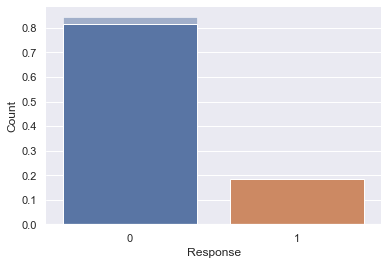

In [80]:
# df value counts mark
counts_dev = pd.DataFrame(data={'Response': [0, 1], 'Count': [mark['Response'].value_counts(normalize=True)[0], mark['Response'].value_counts(normalize=True)[1]]})
# df value counts new dataset
counts_new = pd.DataFrame(data={'Response': [0, 1], 'Count': [mark_sim['Response'].value_counts(normalize=True)[0], mark_sim['Response'].value_counts(normalize=True)[1]]})

# plot distribution of classes on top of each other 
plot = sns.barplot(data=counts_dev, x='Response', y='Count', alpha=0.5)
plot = sns.barplot(data=counts_new, x='Response', y='Count')
sns.despine(left=True)

In [81]:
dev_counts = np.histogram(mark['Response'], bins=2)[0]
new_counts = np.histogram(mark_sim['Response'], bins=2)[0]
breakpoints = [0,1]

In [82]:
df = pd.DataFrame({'Bucket': [0, 1], 'Breakpoint Value':breakpoints, 'Initial Count':dev_counts, 'New Count':new_counts})
df['Initial Percent'] = df['Initial Count'] / mark.shape[0]
df['New Percent'] = df['New Count'] / mark_sim.shape[0]
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent
0,0,0,917,245,0.843606,0.816667
1,1,1,170,55,0.156394,0.183333


In [83]:
df['PSI'] = (df['New Percent'] - df['Initial Percent']) * np.log(df['New Percent'] / df['Initial Percent'])


In [84]:
df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,0,0,917,245,0.843606,0.816667,0.000874
1,1,1,170,55,0.156394,0.183333,0.004281


In [90]:
avg_psi = np.average(df['PSI'])
print(np.round(avg_psi, 3))

0.003


## PSI for classification probability

In [108]:
# load dev dataset with prediction
dev_pred = pd.read_csv('/Applications/documents bob/MSc Data Science/HEC/Data mgmt/monitoring-project/monitoring-project-env/Pipeline_Quinten/Inputs/dev_pred.csv', index_col=0).reset_index(drop=True)

In [110]:
# create artificial sample to imitate new batch
new_pred = dev_pred.sample(n=400)

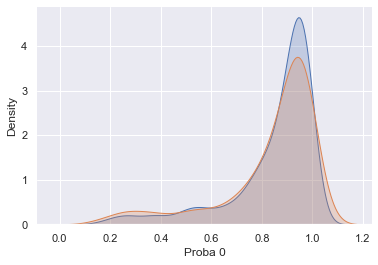

In [112]:
# save array of probabilites of no response (0)
dev_prob = dev_pred['Proba 0']
new_prob = new_pred['Proba 0']

# plot density distribution of both sets
plot = sns.kdeplot(dev_prob, shade=True)
plot = sns.kdeplot(new_prob, shade=True)
sns.despine(left=True)

In [141]:
def scale_range (input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

# define number of buckets for distribution comparison
buckets = 10

# define probability breakpoints for each bucket 
raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
breakpoints = scale_range(raw_breakpoints, np.min(dev_prob), np.max(dev_prob))

In [115]:
# value count of probabilities for each bucket
dev_counts = np.histogram(dev_prob, breakpoints)[0]
new_counts = np.histogram(new_prob, breakpoints)[0]

In [125]:
# create dataframe with buckets for each breakpoint value, counts for dev and new probabilities
psi_df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':dev_counts, 'New Count':new_counts})
psi_df['Initial Percent'] = psi_df['Initial Count'] / len(dev_prob)
psi_df['New Percent'] = psi_df['New Count'] / len(new_prob)

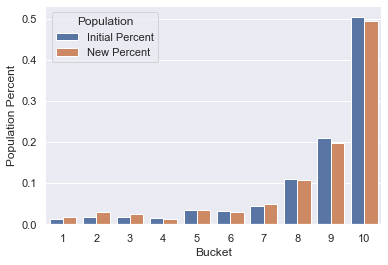

In [128]:
# prep table for barplot representation
percents = psi_df[['Initial Percent', 'New Percent', 'Bucket']] \
             .melt(id_vars=['Bucket']) \
             .rename(columns={'variable':'Population', 'value':'Percent'})

p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
p.set(xlabel='Bucket', ylabel='Population Percent')
sns.despine(left=True)

In [129]:
# add psi value to each bucket
psi_df['PSI'] = (psi_df['New Percent'] - psi_df['Initial Percent']) * np.log(psi_df['New Percent'] / psi_df['Initial Percent'])

In [130]:
psi_df

,Bucket,Breakpoint Value,Initial Count,New Count,Initial Percent,New Percent,PSI
0,1,0.232978,13,7,0.011960,0.0175,0.002109
1,2,0.317888,19,12,0.017479,0.0300,0.006763
2,3,0.402798,19,10,0.017479,0.0250,0.002691
3,4,0.487708,17,5,0.015639,0.0125,0.000703
4,5,0.572618,39,14,0.035879,0.0350,0.000022
5,6,0.657528,35,12,0.032199,0.0300,0.000156
6,7,0.742438,49,20,0.045078,0.0500,0.000510
7,8,0.827348,120,43,0.110396,0.1075,0.000077
8,9,0.912258,229,79,0.210672,0.1975,0.000850
9,10,0.997168,547,198,0.503220,0.4950,0.000135


In [133]:
# get overall PSI
psi_total = np.round(sum(psi_df['PSI']), 3)
psi_total

0.014